# **Customer Churn Prediction**

#### **What is customer churn?**  
Customer churn refers to the percentage of customers who stop using a company's product or service within a given time frame. This metric helps businesses gauge customer satisfaction and loyalty while also providing insights into potential revenue fluctuations.

Churn is especially critical for subscription-based businesses, such as SaaS companies, which rely on recurring revenue. Understanding churn patterns allows them to anticipate financial impact and take proactive measures.

Also known as customer attrition, churn is the opposite of customer retention, which focuses on maintaining long-term customer relationships. Reducing churn should be a key part of any customer engagement strategy, ensuring consistent interactions between businesses and their customers, whether online or in person.

A strong customer retention plan plays a crucial role in minimizing churn. Companies should track churn rates regularly to assess their risk of revenue loss and identify areas for improvement.

<br>

**Source:** IBM. Customer Churn. Retrieved from https://www.ibm.com/think/topics/customer-churn

---

Prepare the libraries.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import shap

from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

from xgboost import XGBClassifier
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Prepare the dataset/s.

In [3]:
pd.pandas.set_option('display.max_columns',None)

train_path = '../data/CustomerChurnDataset/customer_churn_dataset-testing-master.csv'
test_path = '../data/CustomerChurnDataset/customer_churn_dataset-training-master.csv'

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

Since we saw in our EDA that we only have 1 row of missing value/s from test_df lets drop that row.  
Prepare the train and test datasets.

In [4]:
test_df.dropna(inplace=True)

y_train = train_df['Churn']
x_train = train_df.drop(columns=['Churn'])

y_test = test_df['Churn']
x_test = test_df.drop(columns=['Churn'])

Get the numerical and categorical features.

In [5]:
categorical_features = x_train.select_dtypes(include=['object']).columns.tolist()
numerical_features = x_train.select_dtypes(include=['int64','float64']).columns.tolist()

print(categorical_features)
print(numerical_features)

['Gender', 'Subscription Type', 'Contract Length']
['CustomerID', 'Age', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Total Spend', 'Last Interaction']


Prepare the preprocessor for the pipeline.

In [6]:
preprocessor = ColumnTransformer([
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
], remainder='passthrough')

Set up the hyperparameters for tuning.

In [7]:
params_space = {
    'eta': hp.uniform('eta', 0.01,0.2),
    'max_depth': hp.quniform("max_depth", 3, 18, 1),
    'gamma': hp.uniform ('gamma', 1,9),
    'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
    'reg_lambda' : hp.uniform('reg_lambda', 0,1),
    'subsample': hp.uniform('subsample', 0.5,1),
    'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
    'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
    'n_estimators': hp.quniform('n_estimators', 50, 1000, 10),
    'seed': 0
}

def objective(params):
    # convert the quniforms into int since they are float
    params['max_depth'] = int(params['max_depth'])
    params['n_estimators'] = int(params['n_estimators'])
    params['min_child_weight'] = int(params['min_child_weight'])
    params['reg_alpha'] = int(params['reg_alpha'])
    
    pipeline = Pipeline([
        ('preprocessing', preprocessor),
        ('classifier', XGBClassifier(**params, use_label_encoder=False, eval_metric="logloss"))
    ])

    pipeline.fit(x_train, y_train)
    y_pred = pipeline.predict(x_test)
    auc = roc_auc_score(y_test, y_pred)
    print(f"Params: {params}, AUC-ROC: {auc:.4f}")

    return {'loss': -auc, 'status': STATUS_OK}

Run the hyperparameter tuning.


In [8]:
trials = Trials()

best_params = fmin(
    fn = objective,
    space = params_space,
    algo = tpe.suggest,
    max_evals = 100,
    trials = trials
)

print("\n✅ Best Hyperparameters Found:", best_params)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:07:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.7174876588355228, 'eta': 0.1836747552433456, 'gamma': 2.0326132439449873, 'max_depth': 8, 'min_child_weight': 4, 'n_estimators': 830, 'reg_alpha': 86, 'reg_lambda': 0.7064483081019107, 'seed': 0, 'subsample': 0.6076715620591521}, AUC-ROC: 0.4387
  1%|          | 1/100 [00:01<03:12,  1.94s/trial, best loss: -0.43866798265136814]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:07:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.6281745650424001, 'eta': 0.16195065091555616, 'gamma': 7.407928020624863, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 770, 'reg_alpha': 125, 'reg_lambda': 0.7811666796287102, 'seed': 0, 'subsample': 0.6395256590199845}, AUC-ROC: 0.4385
  2%|▏         | 2/100 [00:03<02:57,  1.81s/trial, best loss: -0.43866798265136814]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:07:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.8020427442060549, 'eta': 0.16907038467347263, 'gamma': 2.4341258648174904, 'max_depth': 13, 'min_child_weight': 5, 'n_estimators': 610, 'reg_alpha': 143, 'reg_lambda': 0.32288141783501734, 'seed': 0, 'subsample': 0.7469778780483453}, AUC-ROC: 0.4385
  3%|▎         | 3/100 [00:05<02:48,  1.73s/trial, best loss: -0.43866798265136814]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:08:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.7969500387905228, 'eta': 0.07255677779387583, 'gamma': 4.829600366934395, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 510, 'reg_alpha': 68, 'reg_lambda': 0.008277072453395373, 'seed': 0, 'subsample': 0.649330785187837}, AUC-ROC: 0.7138
  4%|▍         | 4/100 [00:06<02:35,  1.62s/trial, best loss: -0.7137516295580895] 

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:08:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.6403808107900744, 'eta': 0.09172033471130277, 'gamma': 6.5202779802628426, 'max_depth': 17, 'min_child_weight': 2, 'n_estimators': 490, 'reg_alpha': 171, 'reg_lambda': 0.5105171146807975, 'seed': 0, 'subsample': 0.545389581550032}, AUC-ROC: 0.4383
  5%|▌         | 5/100 [00:08<02:26,  1.54s/trial, best loss: -0.7137516295580895]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:08:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.5793408919419323, 'eta': 0.14471949266515644, 'gamma': 1.163925119939421, 'max_depth': 6, 'min_child_weight': 8, 'n_estimators': 980, 'reg_alpha': 72, 'reg_lambda': 0.19384329304384096, 'seed': 0, 'subsample': 0.9103999105409366}, AUC-ROC: 0.6440
  6%|▌         | 6/100 [00:10<02:48,  1.79s/trial, best loss: -0.7137516295580895]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:08:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.6062224335671653, 'eta': 0.12709069009507684, 'gamma': 8.480944351137506, 'max_depth': 15, 'min_child_weight': 10, 'n_estimators': 550, 'reg_alpha': 132, 'reg_lambda': 0.5609694065640378, 'seed': 0, 'subsample': 0.5843631544028314}, AUC-ROC: 0.7345
  7%|▋         | 7/100 [00:12<02:49,  1.82s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:08:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.5912552316546853, 'eta': 0.07080952701785796, 'gamma': 1.7891003933826424, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 320, 'reg_alpha': 138, 'reg_lambda': 0.024860829988120337, 'seed': 0, 'subsample': 0.8415798821449036}, AUC-ROC: 0.6995
  8%|▊         | 8/100 [00:14<02:54,  1.90s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:08:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.5812148171816492, 'eta': 0.07601658737519457, 'gamma': 8.049289713223857, 'max_depth': 12, 'min_child_weight': 8, 'n_estimators': 70, 'reg_alpha': 95, 'reg_lambda': 0.4547641512662355, 'seed': 0, 'subsample': 0.7056268500008268}, AUC-ROC: 0.5002
  9%|▉         | 9/100 [00:15<02:31,  1.66s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:08:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.9499161252344384, 'eta': 0.039456021297331584, 'gamma': 3.2730918147526866, 'max_depth': 13, 'min_child_weight': 3, 'n_estimators': 520, 'reg_alpha': 55, 'reg_lambda': 0.8337372034610997, 'seed': 0, 'subsample': 0.724268377685389}, AUC-ROC: 0.4386
 10%|█         | 10/100 [00:17<02:34,  1.72s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:08:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.9125286313208056, 'eta': 0.14494303876654166, 'gamma': 4.81139571239022, 'max_depth': 13, 'min_child_weight': 10, 'n_estimators': 810, 'reg_alpha': 109, 'reg_lambda': 0.8599298246145103, 'seed': 0, 'subsample': 0.9394807247993662}, AUC-ROC: 0.4386
 11%|█         | 11/100 [00:19<02:44,  1.85s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:08:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.5882967905358113, 'eta': 0.16367388580589032, 'gamma': 3.857732676871662, 'max_depth': 18, 'min_child_weight': 6, 'n_estimators': 300, 'reg_alpha': 63, 'reg_lambda': 0.9430182764040391, 'seed': 0, 'subsample': 0.6298577679158947}, AUC-ROC: 0.6906
 12%|█▏        | 12/100 [00:21<02:36,  1.78s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:08:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.5801931764590423, 'eta': 0.06046388496030268, 'gamma': 6.206177808145742, 'max_depth': 7, 'min_child_weight': 0, 'n_estimators': 810, 'reg_alpha': 63, 'reg_lambda': 0.8833332107089863, 'seed': 0, 'subsample': 0.9060468429620461}, AUC-ROC: 0.6789
 13%|█▎        | 13/100 [00:23<02:47,  1.92s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:08:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.8192433691349794, 'eta': 0.19131719878623654, 'gamma': 2.0448621962868287, 'max_depth': 17, 'min_child_weight': 2, 'n_estimators': 160, 'reg_alpha': 67, 'reg_lambda': 0.8082487616363562, 'seed': 0, 'subsample': 0.8314998196225636}, AUC-ROC: 0.4387
 14%|█▍        | 14/100 [00:24<02:19,  1.63s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:08:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.6811167620692276, 'eta': 0.12980782069004007, 'gamma': 5.6004271870583535, 'max_depth': 5, 'min_child_weight': 9, 'n_estimators': 590, 'reg_alpha': 128, 'reg_lambda': 0.6547758737513361, 'seed': 0, 'subsample': 0.8517255121592242}, AUC-ROC: 0.4385
 15%|█▌        | 15/100 [00:25<02:19,  1.64s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:08:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.9788354448010279, 'eta': 0.19761735886838191, 'gamma': 8.73301030539302, 'max_depth': 17, 'min_child_weight': 3, 'n_estimators': 910, 'reg_alpha': 91, 'reg_lambda': 0.8868003161073165, 'seed': 0, 'subsample': 0.6634433745452106}, AUC-ROC: 0.4385
 16%|█▌        | 16/100 [00:27<02:25,  1.73s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:08:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.7296469454671743, 'eta': 0.08226840931837033, 'gamma': 5.470939332211608, 'max_depth': 8, 'min_child_weight': 9, 'n_estimators': 720, 'reg_alpha': 73, 'reg_lambda': 0.7350596150266534, 'seed': 0, 'subsample': 0.8717684137926518}, AUC-ROC: 0.4386
 17%|█▋        | 17/100 [00:29<02:27,  1.78s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:08:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.698606603004644, 'eta': 0.19014572434587446, 'gamma': 1.8660237329882126, 'max_depth': 14, 'min_child_weight': 5, 'n_estimators': 750, 'reg_alpha': 92, 'reg_lambda': 0.7001768601641994, 'seed': 0, 'subsample': 0.6616694912713307}, AUC-ROC: 0.4386
 18%|█▊        | 18/100 [00:32<02:47,  2.05s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:08:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.8589148185570223, 'eta': 0.15673641143112244, 'gamma': 1.7104895024143136, 'max_depth': 11, 'min_child_weight': 3, 'n_estimators': 790, 'reg_alpha': 155, 'reg_lambda': 0.6538649455372654, 'seed': 0, 'subsample': 0.5395253002652836}, AUC-ROC: 0.4384
 19%|█▉        | 19/100 [00:34<02:44,  2.04s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:08:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.9128063187303224, 'eta': 0.022513637186273208, 'gamma': 2.8763726185660943, 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 530, 'reg_alpha': 164, 'reg_lambda': 0.04769003040706343, 'seed': 0, 'subsample': 0.7170287912579951}, AUC-ROC: 0.4385
 20%|██        | 20/100 [00:36<02:39,  1.99s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:08:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.5231081771281687, 'eta': 0.11550198420263531, 'gamma': 4.08625311809947, 'max_depth': 15, 'min_child_weight': 0, 'n_estimators': 420, 'reg_alpha': 110, 'reg_lambda': 0.502854985881962, 'seed': 0, 'subsample': 0.5761737203717334}, AUC-ROC: 0.7054
 21%|██        | 21/100 [00:37<02:27,  1.87s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:08:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.8047315460721883, 'eta': 0.10464293390701379, 'gamma': 7.297735083964719, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 370, 'reg_alpha': 46, 'reg_lambda': 0.34574777421139846, 'seed': 0, 'subsample': 0.7866065718255504}, AUC-ROC: 0.4386
 22%|██▏       | 22/100 [00:39<02:12,  1.69s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:08:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.7882933284530584, 'eta': 0.05719553662034388, 'gamma': 4.577039571394774, 'max_depth': 15, 'min_child_weight': 6, 'n_estimators': 240, 'reg_alpha': 113, 'reg_lambda': 0.16455390206418005, 'seed': 0, 'subsample': 0.6016246245790322}, AUC-ROC: 0.4385
 23%|██▎       | 23/100 [00:40<01:59,  1.56s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:08:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.5226152256788867, 'eta': 0.010364988167009204, 'gamma': 8.836633025188751, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 630, 'reg_alpha': 45, 'reg_lambda': 0.5714928028072035, 'seed': 0, 'subsample': 0.5038369265815712}, AUC-ROC: 0.4732
 24%|██▍       | 24/100 [00:43<02:25,  1.92s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:08:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.7484412508484192, 'eta': 0.1175575345514638, 'gamma': 6.350448167914309, 'max_depth': 15, 'min_child_weight': 6, 'n_estimators': 440, 'reg_alpha': 151, 'reg_lambda': 0.38621883481025066, 'seed': 0, 'subsample': 0.5306199123593771}, AUC-ROC: 0.4385
 25%|██▌       | 25/100 [00:44<02:16,  1.82s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:08:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.8559865754853271, 'eta': 0.09804511734066962, 'gamma': 5.3729143650699855, 'max_depth': 9, 'min_child_weight': 4, 'n_estimators': 690, 'reg_alpha': 126, 'reg_lambda': 0.231376554128158, 'seed': 0, 'subsample': 0.6779270902269732}, AUC-ROC: 0.4385
 26%|██▌       | 26/100 [00:47<02:22,  1.92s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:08:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.6777740967574785, 'eta': 0.0377991999101598, 'gamma': 7.096168101619834, 'max_depth': 16, 'min_child_weight': 1, 'n_estimators': 200, 'reg_alpha': 103, 'reg_lambda': 0.0815099921404865, 'seed': 0, 'subsample': 0.9988165603650166}, AUC-ROC: 0.4386
 27%|██▋       | 27/100 [00:48<02:16,  1.88s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:08:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.7689232931709339, 'eta': 0.1282733283401519, 'gamma': 3.79372789908989, 'max_depth': 11, 'min_child_weight': 7, 'n_estimators': 640, 'reg_alpha': 82, 'reg_lambda': 0.5862387377705525, 'seed': 0, 'subsample': 0.7697617955319207}, AUC-ROC: 0.4386
 28%|██▊       | 28/100 [00:50<02:11,  1.83s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:08:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.8473158850860117, 'eta': 0.04369326334787767, 'gamma': 8.25780900759847, 'max_depth': 8, 'min_child_weight': 4, 'n_estimators': 870, 'reg_alpha': 177, 'reg_lambda': 0.9986434000702356, 'seed': 0, 'subsample': 0.5851577206031718}, AUC-ROC: 0.4383
 29%|██▉       | 29/100 [00:52<02:15,  1.90s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:08:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.6363764567666005, 'eta': 0.09197691988618369, 'gamma': 4.4327529178757645, 'max_depth': 18, 'min_child_weight': 4, 'n_estimators': 440, 'reg_alpha': 136, 'reg_lambda': 0.41776913358622536, 'seed': 0, 'subsample': 0.5053808885836455}, AUC-ROC: 0.4383
 30%|███       | 30/100 [00:53<02:02,  1.75s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:08:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.7178904500871496, 'eta': 0.1765565888830425, 'gamma': 5.935706936942711, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 550, 'reg_alpha': 81, 'reg_lambda': 0.2965865199830755, 'seed': 0, 'subsample': 0.6216181029886254}, AUC-ROC: 0.6126
 31%|███       | 31/100 [00:55<01:53,  1.65s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:08:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.6596982473569057, 'eta': 0.14359211209664707, 'gamma': 6.765494611461433, 'max_depth': 12, 'min_child_weight': 9, 'n_estimators': 680, 'reg_alpha': 123, 'reg_lambda': 0.11273228011550891, 'seed': 0, 'subsample': 0.5623951252611036}, AUC-ROC: 0.4384
 32%|███▏      | 32/100 [00:57<01:51,  1.64s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:08:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.5013020013825815, 'eta': 0.11386653263912078, 'gamma': 8.058335655241411, 'max_depth': 4, 'min_child_weight': 7, 'n_estimators': 360, 'reg_alpha': 150, 'reg_lambda': 0.5739119125432013, 'seed': 0, 'subsample': 0.6462201446548029}, AUC-ROC: 0.7106
 33%|███▎      | 33/100 [00:58<01:41,  1.52s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:08:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.5507649499618316, 'eta': 0.05957242834297469, 'gamma': 3.1379884071331667, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'reg_alpha': 117, 'reg_lambda': 0.7493789320356876, 'seed': 0, 'subsample': 0.7918357175714105}, AUC-ROC: 0.7223
 34%|███▍      | 34/100 [00:59<01:28,  1.34s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:08:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.5006350603405632, 'eta': 0.02449175559107157, 'gamma': 1.1795603054425472, 'max_depth': 9, 'min_child_weight': 8, 'n_estimators': 70, 'reg_alpha': 160, 'reg_lambda': 0.7534162412038478, 'seed': 0, 'subsample': 0.7945200530994917}, AUC-ROC: 0.6838
 35%|███▌      | 35/100 [00:59<01:16,  1.17s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:08:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.6192466273209518, 'eta': 0.05806426663444731, 'gamma': 3.137248061999795, 'max_depth': 7, 'min_child_weight': 10, 'n_estimators': 140, 'reg_alpha': 118, 'reg_lambda': 0.9988783884570434, 'seed': 0, 'subsample': 0.750731323668232}, AUC-ROC: 0.4385
 36%|███▌      | 36/100 [01:01<01:13,  1.14s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:08:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.5457914342114661, 'eta': 0.1351114563444963, 'gamma': 2.4413895532388317, 'max_depth': 12, 'min_child_weight': 5, 'n_estimators': 280, 'reg_alpha': 134, 'reg_lambda': 0.6357174974371582, 'seed': 0, 'subsample': 0.8110292574523121}, AUC-ROC: 0.6787
 37%|███▋      | 37/100 [01:02<01:11,  1.13s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:08:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.5541604361058697, 'eta': 0.15493133949411564, 'gamma': 3.476811281066458, 'max_depth': 9, 'min_child_weight': 8, 'n_estimators': 970, 'reg_alpha': 101, 'reg_lambda': 0.4710868270499406, 'seed': 0, 'subsample': 0.9787875412312967}, AUC-ROC: 0.6876
 38%|███▊      | 38/100 [01:04<01:25,  1.39s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:08:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.6162170903329576, 'eta': 0.0860350242459362, 'gamma': 2.54595781977232, 'max_depth': 14, 'min_child_weight': 9, 'n_estimators': 580, 'reg_alpha': 141, 'reg_lambda': 0.9277457039671947, 'seed': 0, 'subsample': 0.6965206712801859}, AUC-ROC: 0.4385
 39%|███▉      | 39/100 [01:05<01:26,  1.42s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:09:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.5584196598143037, 'eta': 0.07436935693183025, 'gamma': 7.667287207599839, 'max_depth': 6, 'min_child_weight': 6, 'n_estimators': 490, 'reg_alpha': 173, 'reg_lambda': 0.5412753855245694, 'seed': 0, 'subsample': 0.8810629405954767}, AUC-ROC: 0.7192
 40%|████      | 40/100 [01:06<01:24,  1.41s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:09:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.6032197351997609, 'eta': 0.10378994944432254, 'gamma': 1.047202837909261, 'max_depth': 14, 'min_child_weight': 7, 'n_estimators': 380, 'reg_alpha': 146, 'reg_lambda': 0.7099740597078568, 'seed': 0, 'subsample': 0.7480544167994689}, AUC-ROC: 0.6843
 41%|████      | 41/100 [01:08<01:20,  1.36s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:09:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.6520188776773614, 'eta': 0.0627157032609362, 'gamma': 5.073751129804769, 'max_depth': 12, 'min_child_weight': 2, 'n_estimators': 90, 'reg_alpha': 119, 'reg_lambda': 0.7826095231460202, 'seed': 0, 'subsample': 0.947751118193819}, AUC-ROC: 0.4385
 42%|████▏     | 42/100 [01:09<01:10,  1.22s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:09:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.5234075624780408, 'eta': 0.17114506662774778, 'gamma': 4.3091644422309425, 'max_depth': 8, 'min_child_weight': 5, 'n_estimators': 330, 'reg_alpha': 131, 'reg_lambda': 0.45928820798598524, 'seed': 0, 'subsample': 0.6839732983710152}, AUC-ROC: 0.7045
 43%|████▎     | 43/100 [01:10<01:08,  1.21s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:09:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.5595801507803811, 'eta': 0.0510290044944456, 'gamma': 3.5505942122752256, 'max_depth': 16, 'min_child_weight': 10, 'n_estimators': 480, 'reg_alpha': 102, 'reg_lambda': 0.6097550173688884, 'seed': 0, 'subsample': 0.8141695426724314}, AUC-ROC: 0.6826
 44%|████▍     | 44/100 [01:11<01:14,  1.34s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:09:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.696504367099213, 'eta': 0.019226925551082755, 'gamma': 1.5094580886246827, 'max_depth': 13, 'min_child_weight': 3, 'n_estimators': 120, 'reg_alpha': 161, 'reg_lambda': 0.26436815266942404, 'seed': 0, 'subsample': 0.7241811917553981}, AUC-ROC: 0.4373
 45%|████▌     | 45/100 [01:12<01:07,  1.23s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:09:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.5950258782594838, 'eta': 0.03247315095460625, 'gamma': 2.819167527222434, 'max_depth': 6, 'min_child_weight': 4, 'n_estimators': 250, 'reg_alpha': 116, 'reg_lambda': 0.83103456062682, 'seed': 0, 'subsample': 0.8954775814418556}, AUC-ROC: 0.6377
 46%|████▌     | 46/100 [01:14<01:08,  1.28s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:09:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.7382325853073395, 'eta': 0.12501667925913693, 'gamma': 5.086351277092765, 'max_depth': 11, 'min_child_weight': 8, 'n_estimators': 750, 'reg_alpha': 87, 'reg_lambda': 0.38363240795665327, 'seed': 0, 'subsample': 0.8564654541451638}, AUC-ROC: 0.4386
 47%|████▋     | 47/100 [01:16<01:14,  1.41s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:09:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.6727795780339713, 'eta': 0.06846322774979352, 'gamma': 5.871238044617745, 'max_depth': 10, 'min_child_weight': 9, 'n_estimators': 840, 'reg_alpha': 106, 'reg_lambda': 0.6818107153259965, 'seed': 0, 'subsample': 0.947367117029567}, AUC-ROC: 0.6829
 48%|████▊     | 48/100 [01:17<01:22,  1.58s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:09:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.5352344525169451, 'eta': 0.13843959936668443, 'gamma': 2.0930474136878714, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 570, 'reg_alpha': 169, 'reg_lambda': 0.9246510338555859, 'seed': 0, 'subsample': 0.7648303443461261}, AUC-ROC: 0.6955
 49%|████▉     | 49/100 [01:19<01:19,  1.56s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:09:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.5022171190984058, 'eta': 0.08186411692265504, 'gamma': 8.47574157072681, 'max_depth': 5, 'min_child_weight': 6, 'n_estimators': 180, 'reg_alpha': 95, 'reg_lambda': 0.5307216091652088, 'seed': 0, 'subsample': 0.9212972792587685}, AUC-ROC: 0.7030
 50%|█████     | 50/100 [01:20<01:09,  1.40s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:09:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.576848168955652, 'eta': 0.15100694667348274, 'gamma': 7.618158962619665, 'max_depth': 18, 'min_child_weight': 0, 'n_estimators': 930, 'reg_alpha': 145, 'reg_lambda': 0.744217496507141, 'seed': 0, 'subsample': 0.6081267975870129}, AUC-ROC: 0.7241
 51%|█████     | 51/100 [01:22<01:15,  1.55s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:09:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.5748199905795549, 'eta': 0.18363189162791488, 'gamma': 7.553329574818503, 'max_depth': 17, 'min_child_weight': 3, 'n_estimators': 950, 'reg_alpha': 156, 'reg_lambda': 0.8617181414674309, 'seed': 0, 'subsample': 0.5224034336463828}, AUC-ROC: 0.4702
 52%|█████▏    | 52/100 [01:24<01:20,  1.67s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:09:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.7017202727202003, 'eta': 0.15353355759093956, 'gamma': 7.036250489943431, 'max_depth': 18, 'min_child_weight': 1, 'n_estimators': 920, 'reg_alpha': 146, 'reg_lambda': 0.9718167823219628, 'seed': 0, 'subsample': 0.6076602409777445}, AUC-ROC: 0.4386
 53%|█████▎    | 53/100 [01:26<01:22,  1.76s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:09:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.7651478445160712, 'eta': 0.16426413159311481, 'gamma': 7.775077079718128, 'max_depth': 16, 'min_child_weight': 0, 'n_estimators': 1000, 'reg_alpha': 179, 'reg_lambda': 0.7886443518499308, 'seed': 0, 'subsample': 0.5822322412632591}, AUC-ROC: 0.4385
 54%|█████▍    | 54/100 [01:28<01:24,  1.83s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:09:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.6286984512521862, 'eta': 0.12066210756002972, 'gamma': 8.97437460478328, 'max_depth': 17, 'min_child_weight': 2, 'n_estimators': 670, 'reg_alpha': 166, 'reg_lambda': 0.3419799886450286, 'seed': 0, 'subsample': 0.6360933247224126}, AUC-ROC: 0.4385
 55%|█████▌    | 55/100 [01:29<01:19,  1.77s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:09:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.9931768477598845, 'eta': 0.19478916947886418, 'gamma': 8.483559843812772, 'max_depth': 18, 'min_child_weight': 0, 'n_estimators': 880, 'reg_alpha': 140, 'reg_lambda': 0.6203801985423895, 'seed': 0, 'subsample': 0.5499138213709018}, AUC-ROC: 0.4384
 56%|█████▌    | 56/100 [01:31<01:19,  1.80s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:09:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.6504735648406428, 'eta': 0.172820069177971, 'gamma': 6.710661959883718, 'max_depth': 14, 'min_child_weight': 1, 'n_estimators': 780, 'reg_alpha': 124, 'reg_lambda': 0.6816397249513149, 'seed': 0, 'subsample': 0.515697660028579}, AUC-ROC: 0.4385
 57%|█████▋    | 57/100 [01:33<01:16,  1.77s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:09:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.5818059453328802, 'eta': 0.11086928829744602, 'gamma': 7.965892343206271, 'max_depth': 16, 'min_child_weight': 10, 'n_estimators': 840, 'reg_alpha': 131, 'reg_lambda': 0.41502982644505026, 'seed': 0, 'subsample': 0.6656171490989631}, AUC-ROC: 0.7021
 58%|█████▊    | 58/100 [01:35<01:16,  1.82s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:09:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.9189906912800477, 'eta': 0.18170224370404028, 'gamma': 8.66484226494417, 'max_depth': 15, 'min_child_weight': 0, 'n_estimators': 610, 'reg_alpha': 155, 'reg_lambda': 0.5416546907917589, 'seed': 0, 'subsample': 0.6165750745968823}, AUC-ROC: 0.4385
 59%|█████▉    | 59/100 [01:36<01:10,  1.72s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:09:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.8357689676513331, 'eta': 0.1510172132596353, 'gamma': 6.224506672875011, 'max_depth': 17, 'min_child_weight': 3, 'n_estimators': 720, 'reg_alpha': 110, 'reg_lambda': 0.4960394005555455, 'seed': 0, 'subsample': 0.5958579555237848}, AUC-ROC: 0.4385
 60%|██████    | 60/100 [01:38<01:08,  1.71s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:09:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.6067758438089188, 'eta': 0.1342641782350484, 'gamma': 7.369106580618852, 'max_depth': 18, 'min_child_weight': 8, 'n_estimators': 710, 'reg_alpha': 144, 'reg_lambda': 0.719347214905523, 'seed': 0, 'subsample': 0.5420695110606364}, AUC-ROC: 0.6942
 61%|██████    | 61/100 [01:40<01:06,  1.71s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:09:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.8815234714863964, 'eta': 0.16523274198087018, 'gamma': 6.986198137842825, 'max_depth': 16, 'min_child_weight': 7, 'n_estimators': 410, 'reg_alpha': 152, 'reg_lambda': 0.8198555326628185, 'seed': 0, 'subsample': 0.5566814317837887}, AUC-ROC: 0.4384
 62%|██████▏   | 62/100 [01:41<00:59,  1.57s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:09:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.7099368106799196, 'eta': 0.14734706913537143, 'gamma': 8.959748951831118, 'max_depth': 17, 'min_child_weight': 9, 'n_estimators': 920, 'reg_alpha': 56, 'reg_lambda': 0.8660078313660063, 'seed': 0, 'subsample': 0.709391917976128}, AUC-ROC: 0.4387
 63%|██████▎   | 63/100 [01:43<01:01,  1.67s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:09:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.7832947191858681, 'eta': 0.09613341493109803, 'gamma': 6.479445633390062, 'max_depth': 13, 'min_child_weight': 6, 'n_estimators': 470, 'reg_alpha': 136, 'reg_lambda': 0.1680167994754469, 'seed': 0, 'subsample': 0.5655970808688972}, AUC-ROC: 0.4384
 64%|██████▍   | 64/100 [01:44<00:56,  1.58s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:09:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.5726553689275191, 'eta': 0.15834529283872556, 'gamma': 5.909594718879495, 'max_depth': 15, 'min_child_weight': 4, 'n_estimators': 640, 'reg_alpha': 40, 'reg_lambda': 0.4297506584219891, 'seed': 0, 'subsample': 0.6497342521192048}, AUC-ROC: 0.6672
 65%|██████▌   | 65/100 [01:46<00:55,  1.59s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:09:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.5159746352439866, 'eta': 0.1099189153720912, 'gamma': 4.709935134579298, 'max_depth': 11, 'min_child_weight': 2, 'n_estimators': 230, 'reg_alpha': 114, 'reg_lambda': 0.7523985325814286, 'seed': 0, 'subsample': 0.7853664491905518}, AUC-ROC: 0.6985
 66%|██████▌   | 66/100 [01:47<00:49,  1.45s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:09:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.5347756642206027, 'eta': 0.12263564943304689, 'gamma': 4.018024044864646, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 320, 'reg_alpha': 122, 'reg_lambda': 0.7502316773018071, 'seed': 0, 'subsample': 0.8203200215962567}, AUC-ROC: 0.7028
 67%|██████▋   | 67/100 [01:48<00:45,  1.37s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:09:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.6401750009994281, 'eta': 0.0473669088306905, 'gamma': 2.20442710943382, 'max_depth': 10, 'min_child_weight': 7, 'n_estimators': 540, 'reg_alpha': 76, 'reg_lambda': 0.905902248775424, 'seed': 0, 'subsample': 0.7320352882474759}, AUC-ROC: 0.6437
 68%|██████▊   | 68/100 [01:50<00:48,  1.51s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:09:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.6179618232784917, 'eta': 0.13879638539571873, 'gamma': 5.273732213960467, 'max_depth': 7, 'min_child_weight': 2, 'n_estimators': 760, 'reg_alpha': 106, 'reg_lambda': 0.6510432137538255, 'seed': 0, 'subsample': 0.6966360172842457}, AUC-ROC: 0.4385
 69%|██████▉   | 69/100 [01:52<00:48,  1.58s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:09:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.6614439603549497, 'eta': 0.13090312857873354, 'gamma': 8.272598141030622, 'max_depth': 8, 'min_child_weight': 4, 'n_estimators': 510, 'reg_alpha': 96, 'reg_lambda': 0.5988324678458794, 'seed': 0, 'subsample': 0.7391174582030972}, AUC-ROC: 0.4386
 70%|███████   | 70/100 [01:53<00:45,  1.53s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:09:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.6832316972885484, 'eta': 0.01205719301393035, 'gamma': 1.3672106766116616, 'max_depth': 13, 'min_child_weight': 1, 'n_estimators': 280, 'reg_alpha': 128, 'reg_lambda': 0.684748713401814, 'seed': 0, 'subsample': 0.6815177495329358}, AUC-ROC: 0.4383
 71%|███████   | 71/100 [01:55<00:44,  1.54s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:09:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.5110241548213499, 'eta': 0.10135285277078979, 'gamma': 5.596629475640525, 'max_depth': 12, 'min_child_weight': 6, 'n_estimators': 880, 'reg_alpha': 130, 'reg_lambda': 0.5645554778790668, 'seed': 0, 'subsample': 0.842833884014129}, AUC-ROC: 0.7028
 72%|███████▏  | 72/100 [01:57<00:46,  1.65s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:09:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.5418742935844153, 'eta': 0.08957393033533145, 'gamma': 2.706675893629944, 'max_depth': 4, 'min_child_weight': 10, 'n_estimators': 810, 'reg_alpha': 119, 'reg_lambda': 0.7985768637173604, 'seed': 0, 'subsample': 0.7647766397396474}, AUC-ROC: 0.7030
 73%|███████▎  | 73/100 [01:59<00:46,  1.73s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:09:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.5666581368932482, 'eta': 0.07719583072269535, 'gamma': 3.5414729611191986, 'max_depth': 14, 'min_child_weight': 8, 'n_estimators': 390, 'reg_alpha': 149, 'reg_lambda': 0.9583246627719857, 'seed': 0, 'subsample': 0.798000798952528}, AUC-ROC: 0.7140
 74%|███████▍  | 74/100 [02:00<00:42,  1.62s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:09:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.5947481004806353, 'eta': 0.0657184673503453, 'gamma': 3.108307303504035, 'max_depth': 8, 'min_child_weight': 3, 'n_estimators': 50, 'reg_alpha': 138, 'reg_lambda': 0.8860720814278285, 'seed': 0, 'subsample': 0.6572863308660972}, AUC-ROC: 0.4374
 75%|███████▌  | 75/100 [02:01<00:34,  1.36s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:09:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.6110570400184041, 'eta': 0.10823752574515841, 'gamma': 7.799533714484777, 'max_depth': 9, 'min_child_weight': 9, 'n_estimators': 120, 'reg_alpha': 98, 'reg_lambda': 0.6281244808680365, 'seed': 0, 'subsample': 0.6310541065835769}, AUC-ROC: 0.7022
 76%|███████▌  | 76/100 [02:02<00:29,  1.23s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:09:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.7281281733439641, 'eta': 0.05248500249663105, 'gamma': 4.16809427972493, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 340, 'reg_alpha': 90, 'reg_lambda': 0.4807108908818333, 'seed': 0, 'subsample': 0.8590683911867114}, AUC-ROC: 0.4386
 77%|███████▋  | 77/100 [02:03<00:29,  1.27s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:09:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.5851658753130893, 'eta': 0.03671778255297069, 'gamma': 6.688701329214971, 'max_depth': 12, 'min_child_weight': 7, 'n_estimators': 220, 'reg_alpha': 143, 'reg_lambda': 0.7223744010072144, 'seed': 0, 'subsample': 0.5913829200745153}, AUC-ROC: 0.6320
 78%|███████▊  | 78/100 [02:04<00:27,  1.27s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:10:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.5485851918744598, 'eta': 0.11594995582311285, 'gamma': 3.800123640806293, 'max_depth': 11, 'min_child_weight': 0, 'n_estimators': 280, 'reg_alpha': 134, 'reg_lambda': 0.8402663436835429, 'seed': 0, 'subsample': 0.5710813241172534}, AUC-ROC: 0.6943
 79%|███████▉  | 79/100 [02:06<00:26,  1.25s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:10:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.630895493646136, 'eta': 0.18830198218314131, 'gamma': 7.250163352461034, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 440, 'reg_alpha': 160, 'reg_lambda': 0.6650549483911099, 'seed': 0, 'subsample': 0.8291728058682142}, AUC-ROC: 0.4385
 80%|████████  | 80/100 [02:07<00:25,  1.25s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:10:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.6702750994022911, 'eta': 0.17837744608729844, 'gamma': 8.034217106382092, 'max_depth': 13, 'min_child_weight': 1, 'n_estimators': 660, 'reg_alpha': 173, 'reg_lambda': 0.5205799004277856, 'seed': 0, 'subsample': 0.7764514152402295}, AUC-ROC: 0.4385
 81%|████████  | 81/100 [02:08<00:25,  1.34s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:10:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.6925250068641858, 'eta': 0.1463157509257097, 'gamma': 3.330736971500678, 'max_depth': 15, 'min_child_weight': 10, 'n_estimators': 960, 'reg_alpha': 114, 'reg_lambda': 0.7679276998751213, 'seed': 0, 'subsample': 0.5311350445999332}, AUC-ROC: 0.4385
 82%|████████▏ | 82/100 [02:10<00:27,  1.55s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:10:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.5314929563579787, 'eta': 0.1274030959656713, 'gamma': 4.953329466740358, 'max_depth': 18, 'min_child_weight': 6, 'n_estimators': 610, 'reg_alpha': 166, 'reg_lambda': 0.30375937247376217, 'seed': 0, 'subsample': 0.6140788257270396}, AUC-ROC: 0.6848
 83%|████████▎ | 83/100 [02:12<00:26,  1.57s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:10:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.753059050818365, 'eta': 0.1419079859463712, 'gamma': 8.709636834669508, 'max_depth': 16, 'min_child_weight': 3, 'n_estimators': 990, 'reg_alpha': 107, 'reg_lambda': 0.3803710846723171, 'seed': 0, 'subsample': 0.6903508854467016}, AUC-ROC: 0.4386
 84%|████████▍ | 84/100 [02:14<00:27,  1.71s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:10:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.8138633233022734, 'eta': 0.07930004633803941, 'gamma': 8.265512587948182, 'max_depth': 10, 'min_child_weight': 2, 'n_estimators': 560, 'reg_alpha': 121, 'reg_lambda': 0.5719064947125412, 'seed': 0, 'subsample': 0.6723227082190232}, AUC-ROC: 0.4385
 85%|████████▌ | 85/100 [02:16<00:24,  1.65s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:10:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.5658691377968561, 'eta': 0.19910916907243292, 'gamma': 7.533010486808285, 'max_depth': 17, 'min_child_weight': 8, 'n_estimators': 740, 'reg_alpha': 83, 'reg_lambda': 0.22953948136525876, 'seed': 0, 'subsample': 0.8783629302152677}, AUC-ROC: 0.7180
 86%|████████▌ | 86/100 [02:17<00:23,  1.65s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:10:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.5078111733225923, 'eta': 0.15828219180251824, 'gamma': 4.516269383621747, 'max_depth': 12, 'min_child_weight': 9, 'n_estimators': 170, 'reg_alpha': 125, 'reg_lambda': 0.43854555663993017, 'seed': 0, 'subsample': 0.7143315402064554}, AUC-ROC: 0.7094
 87%|████████▋ | 87/100 [02:18<00:18,  1.46s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:10:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.6522253390041204, 'eta': 0.08860943742185869, 'gamma': 5.701467334484066, 'max_depth': 14, 'min_child_weight': 4, 'n_estimators': 200, 'reg_alpha': 157, 'reg_lambda': 0.6971395643608439, 'seed': 0, 'subsample': 0.9730862449080304}, AUC-ROC: 0.4385
 88%|████████▊ | 88/100 [02:19<00:16,  1.34s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:10:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.5246634138185441, 'eta': 0.0852363313947608, 'gamma': 1.764655561446509, 'max_depth': 7, 'min_child_weight': 7, 'n_estimators': 520, 'reg_alpha': 128, 'reg_lambda': 0.00014321097410924244, 'seed': 0, 'subsample': 0.5089460612281804}, AUC-ROC: 0.7121
 89%|████████▉ | 89/100 [02:21<00:15,  1.40s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:10:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.5991599654636729, 'eta': 0.09602291397107837, 'gamma': 6.08511283721122, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 80, 'reg_alpha': 99, 'reg_lambda': 0.5486976180134078, 'seed': 0, 'subsample': 0.7584582349357071}, AUC-ROC: 0.7122
 90%|█████████ | 90/100 [02:22<00:12,  1.25s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:10:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.5452950144859181, 'eta': 0.07120693113176263, 'gamma': 6.898461591933808, 'max_depth': 15, 'min_child_weight': 0, 'n_estimators': 800, 'reg_alpha': 147, 'reg_lambda': 0.5902731809669388, 'seed': 0, 'subsample': 0.9192332661816143}, AUC-ROC: 0.7085
 91%|█████████ | 91/100 [02:24<00:12,  1.43s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:10:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.7222660994349809, 'eta': 0.1676358608502515, 'gamma': 8.439918932730858, 'max_depth': 8, 'min_child_weight': 7, 'n_estimators': 860, 'reg_alpha': 152, 'reg_lambda': 0.8439660017395235, 'seed': 0, 'subsample': 0.8036936050498771}, AUC-ROC: 0.4386
 92%|█████████▏| 92/100 [02:25<00:12,  1.54s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:10:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.7401263879884789, 'eta': 0.11815365586239615, 'gamma': 7.197917778406019, 'max_depth': 18, 'min_child_weight': 5, 'n_estimators': 590, 'reg_alpha': 140, 'reg_lambda': 0.5036278411805066, 'seed': 0, 'subsample': 0.7374184328970356}, AUC-ROC: 0.4385
 93%|█████████▎| 93/100 [02:27<00:10,  1.53s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:10:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.6224579193675759, 'eta': 0.1505927596490661, 'gamma': 6.475822781842868, 'max_depth': 10, 'min_child_weight': 3, 'n_estimators': 940, 'reg_alpha': 112, 'reg_lambda': 0.7273330555759956, 'seed': 0, 'subsample': 0.6455146542894835}, AUC-ROC: 0.4385
 94%|█████████▍| 94/100 [02:29<00:09,  1.65s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:10:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.5581417162107141, 'eta': 0.027594085430673924, 'gamma': 8.834883038860777, 'max_depth': 11, 'min_child_weight': 6, 'n_estimators': 300, 'reg_alpha': 64, 'reg_lambda': 0.8122501882039618, 'seed': 0, 'subsample': 0.6268743510196728}, AUC-ROC: 0.6337
 95%|█████████▌| 95/100 [02:30<00:08,  1.64s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:10:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.9364893016312185, 'eta': 0.10123769405665811, 'gamma': 2.3042181556943335, 'max_depth': 17, 'min_child_weight': 10, 'n_estimators': 470, 'reg_alpha': 78, 'reg_lambda': 0.9876395924997237, 'seed': 0, 'subsample': 0.6062839125179433}, AUC-ROC: 0.4386
 96%|█████████▌| 96/100 [02:32<00:06,  1.58s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:10:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.5000984986364486, 'eta': 0.17608200549053205, 'gamma': 3.0122974253440074, 'max_depth': 16, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 104, 'reg_lambda': 0.6446018264986739, 'seed': 0, 'subsample': 0.8969049695717324}, AUC-ROC: 0.6966
 97%|█████████▋| 97/100 [02:33<00:04,  1.37s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:10:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.6423175425567706, 'eta': 0.04312175320967117, 'gamma': 3.670764539203895, 'max_depth': 6, 'min_child_weight': 0, 'n_estimators': 50, 'reg_alpha': 134, 'reg_lambda': 0.9344494893915929, 'seed': 0, 'subsample': 0.6997222656149851}, AUC-ROC: 0.4368
 98%|█████████▊| 98/100 [02:33<00:02,  1.17s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:10:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.7101900171640396, 'eta': 0.016963830925000548, 'gamma': 5.304651422228366, 'max_depth': 14, 'min_child_weight': 2, 'n_estimators': 360, 'reg_alpha': 170, 'reg_lambda': 0.9093404975024058, 'seed': 0, 'subsample': 0.725588887364493}, AUC-ROC: 0.4384
 99%|█████████▉| 99/100 [02:35<00:01,  1.34s/trial, best loss: -0.7344770083989864]

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:10:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Params: {'colsample_bytree': 0.8762270006728332, 'eta': 0.1606264750316262, 'gamma': 4.830849238577614, 'max_depth': 13, 'min_child_weight': 9, 'n_estimators': 690, 'reg_alpha': 110, 'reg_lambda': 0.36296973790453163, 'seed': 0, 'subsample': 0.5772828349758243}, AUC-ROC: 0.4385
100%|██████████| 100/100 [02:37<00:00,  1.57s/trial, best loss: -0.7344770083989864]

✅ Best Hyperparameters Found: {'colsample_bytree': np.float64(0.6062224335671653), 'eta': np.float64(0.12709069009507684), 'gamma': np.float64(8.480944351137506), 'max_depth': np.float64(15.0), 'min_child_weight': np.float64(10.0), 'n_estimators': np.float64(550.0), 'reg_alpha': np.float64(132.0), 'reg_lambda': np.float64(0.5609694065640378), 'subsample': np.float64(0.5843631544028314)}


Get the best hyperparameters.


In [9]:
int_params = {"max_depth", "n_estimators", "min_child_weight", "reg_alpha"}

def convert_params(params):
    return {k: int(v) if k in int_params else float(v) for k, v in params.items()}

best_params = convert_params(best_params)

Create the pipeline.

In [10]:
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', XGBClassifier(**best_params))
])

Train the model and make predictions.

In [11]:
pipeline.fit(x_train, y_train)

y_pred = pipeline.predict(x_test)
y_proba = pipeline.predict_proba(x_test) 

Evaluate the model.

In [12]:
def evaluate_model(test, pred, proba):
    accuracy = accuracy_score(test, pred)
    auc_roc = roc_auc_score(test, proba[:, 1]) 
    
    print(f"Final Model Accuracy: {accuracy:.4f}")
    print("XGBoost Classification Report:\n", classification_report(test, pred))
    # print("XGBoost AUC-ROC:", roc_auc_score(test, pred))
    print(f"XGBoost AUC-ROC: {auc_roc:.4f}")
    
evaluate_model(y_test, y_pred, y_proba)

Final Model Accuracy: 0.7457
XGBoost Classification Report:
               precision    recall  f1-score   support

         0.0       0.73      0.65      0.69    190833
         1.0       0.75      0.82      0.78    249999

    accuracy                           0.75    440832
   macro avg       0.74      0.73      0.74    440832
weighted avg       0.74      0.75      0.74    440832

XGBoost AUC-ROC: 0.7244


Prepare SHAP

100%|===================| 440637/440832 [08:18<00:00]        

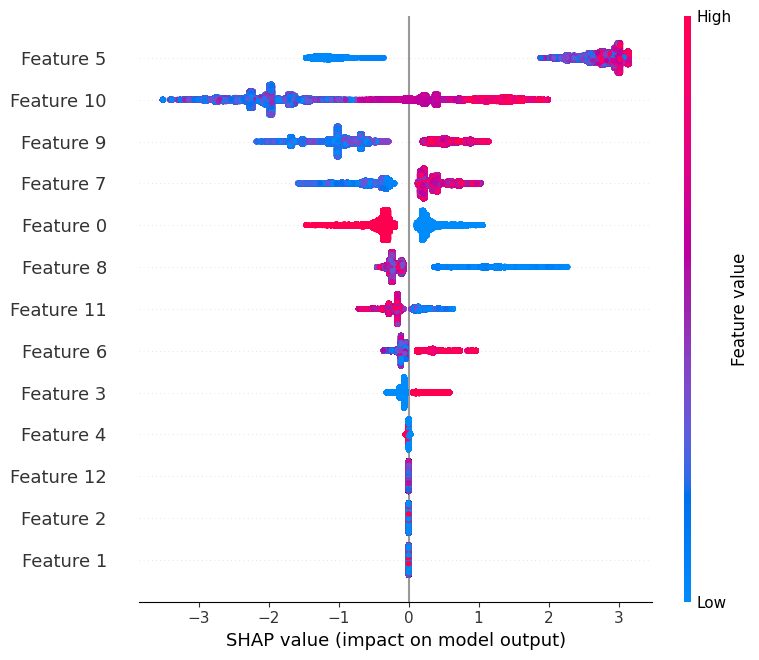

In [ ]:
# model = pipeline.named_steps['classifier']
# x_train_processed = pipeline.named_steps['preprocessing'].transform(x_train)
# x_test_processed = pipeline.named_steps['preprocessing'].transform(x_test)

# explainer = shap.Explainer(model, x_train_processed)
# shap_values = explainer(x_test_processed)
# shap.summary_plot(shap_values, x_test_processed)

In [ ]:
# shap.dependence_plot("Churn", shap_values, x_test_processed)

ValueError: Could not find feature named: Churn